In [1]:
# Read filtered ts

import pickle

longsubs = pickle.load(open('/home/anton/Documents/Tulane/Research/Work/ADNI/long_sub_scans_ts_tsfilt.pkl', 'rb'))

print(len(longsubs))

699


In [2]:
# Get healthy controls

import pandas

df = pandas.read_csv('/run/media/anton/AntonData1/ADNI/PTDEMOG.csv')

df['PTADDX']

0          NaN
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
4847       NaN
4848       NaN
4849    9999.0
4850    9999.0
4851       NaN
Name: PTADDX, Length: 4852, dtype: float64

In [20]:
# Get two fcs for most subs

import numpy as np
from math import isnan

first = []
second = []

for i,sub in enumerate(longsubs):
    # No MCI or AD
    id = sub['name'].split('_')[-1]
    id = int(id)
    row = df[df['RID'] == id]
    cogbeg = row['PTCOGBEG'].array[0]
    mcibeg = row['PTMCIBEG'].array[0]
    adbeg = row['PTADBEG'].array[0]
    addx = row['PTADDX'].array[0]
    if not isnan(cogbeg) and cogbeg != 9999.0:
        continue
    if not isnan(mcibeg):
        continue
    if not isnan(adbeg) and adbeg > 0:
        continue
    if not isnan(addx) and addx != 9999.0:
        continue
    scans = [scan for scan in sub['scans'] if 'tsfilt' in scan and scan['tr'] < 6]
    if len(scans) < 2:
        continue
    scans = sorted(scans, key=lambda x: int(x['year'])*12+int(x['month']), reverse=False)
    # print([scan['year'] for scan in scans])
    p0 = np.corrcoef(scans[0]['tsfilt'])
    p1 = np.corrcoef(scans[1]['tsfilt'])
    if np.sum(np.isnan(p0)) > 0 or np.sum(np.isnan(p1)) > 0:
        print(f'{i} Bad sub {sub["name"]}')
        continue
    first.append(p0)
    second.append(p1)
    if i%50 == 0:
        print(f'Done {i}')

first = np.stack(first)
second = np.stack(second)

print(first.shape, second.shape)

Done 100
Done 500
686 Bad sub 031_S_4021
(349, 264, 264) (349, 264, 264)


In [4]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


0.014819442929469184
0.13130270290244117
184 165 0.5272206303724928


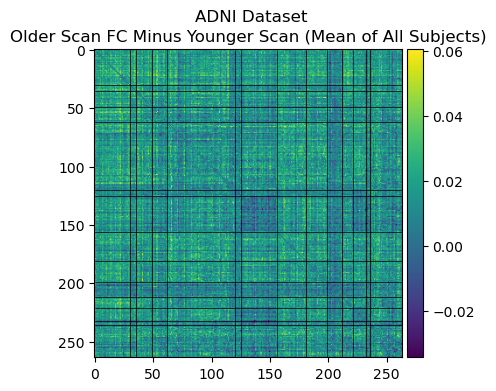

In [29]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

print(np.mean(second)-np.mean(first))
diff = np.mean(second, axis=(1,2))-np.mean(first, axis=(1,2))
print(np.std(diff))
numPlus = np.sum(diff > 0)
numMinus = np.sum(diff < 0)
print(numPlus, numMinus, numPlus/(numPlus+numMinus))

bounds = [0, 30, 35, 49, 62, 120, 125, 156, 181, 199, 212, 221, 232, 236, 264]

fig,ax = plt.subplots(1,1,figsize=(6,4))

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(remap(np.mean(second, axis=0)-np.mean(first, axis=0)))

for a in bounds[1:-1]:
    ax.plot([a,a],[0,263], color='black', linewidth=0.5)
    ax.plot([0,263],[a,a], color='black', linewidth=0.5)

ax.set_title('Older Scan FC Minus Younger Scan (Mean of All Subjects)')

fig.colorbar(im, cax=cax, orientation='vertical')

fig.suptitle('ADNI Dataset')
fig.show()
fig.savefig('/home/anton/Documents/Tulane/Research/Work/ADNI/adni_scan2_minus_scan1.pdf')

In [15]:
bounds = [0, 30, 35, 49, 62, 120, 125, 156, 181, 199, 212, 221, 232, 236, 264]


for a in range(14):
    for b in range(a,14):
        s1 = np.arange(bounds[a], bounds[b+1])
        s2 = np.arange(bounds[a], bounds[b+1])
        
        m = remap(np.mean(second, axis=0)-np.mean(first, axis=0))
        c = m[np.ix_(s1,s2)].flatten()
        print(a,b,np.mean(c))

0 0 0.02031875547355521
0 1 0.02132145143175759
0 2 0.020095193022778058
0 3 0.019562057946011187
0 4 0.017301228630074567
0 5 0.0166896583221236
0 6 0.01590280445818115
0 7 0.016721328929619982
0 8 0.016834626032255127
0 9 0.01578349615637454
0 10 0.015890602969589517
0 11 0.016016426312900203
0 12 0.015795635467067633
0 13 0.015631265815301047
1 1 0.015520772920564294
1 2 0.016544043499830765
1 3 0.01576653606875858
1 4 0.015480529351042691
1 5 0.014792538200942744
1 6 0.014202567080995212
1 7 0.015648622404799774
1 8 0.015868613914376488
1 9 0.01475867867324668
1 10 0.014868313657661782
1 11 0.01506043658713148
1 12 0.01484058892041621
1 13 0.014798055166443273
2 2 0.01565198696900358
2 3 0.015193380315616376
2 4 0.015246909458500948
2 5 0.014550342814485613
2 6 0.014021529595550043
2 7 0.015587595359558018
2 8 0.01584416984413709
2 9 0.014714779537900657
2 10 0.01481817515891207
2 11 0.015003331021713022
2 12 0.014784203195798177
2 13 0.014744164343145558
3 3 0.012094168033175605
3

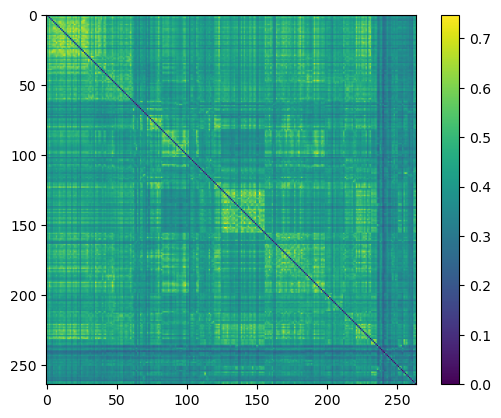

In [138]:
img = remap(np.mean(second, axis=0))
img = img*(1-np.eye(264))

plt.imshow(img)
plt.colorbar()
plt.show()

In [131]:
a,b = np.triu_indices(264,1)

fo = first[:,a,b]
so = second[:,a,b]

diff = so-fo

print(diff.shape)

(693, 34716)


In [136]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

N = 340

errs = []
nullerrs = []

for _ in range(10):
    idcs = np.random.permutation(len(fo))

    a = fo-so
    b = so-fo

    x = np.concatenate([a[idcs[:N]], b[idcs[N:N*2]]])
    y = np.concatenate([np.zeros(N), np.ones(N)])

    xtr, xt, ytr, yt = train_test_split(x, y, stratify=y, train_size=0.8)

    reg = LogisticRegression(max_iter=1000).fit(xtr, ytr)
    yhat = reg.predict(xt)
    err = np.mean(yhat == yt)
    nullerr = np.mean(yt)
    if nullerr < 0.5:
        nullerr = 1-nullerr
    print(err)
    print(nullerr)
    errs.append(err)
    nullerrs.append(nullerr)
    
print(np.mean(errs), np.std(errs))
print(np.mean(nullerrs), np.std(nullerrs))

0.5808823529411765
0.5
0.5735294117647058
0.5
0.5294117647058824
0.5
0.6323529411764706
0.5
0.5955882352941176
0.5
0.5294117647058824
0.5
0.5367647058823529
0.5
0.5441176470588235
0.5
0.5735294117647058
0.5
0.5220588235294118
0.5
0.5617647058823529 0.033727485121116806
0.5 0.0
